In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_massver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'train_mass_labels2_num.npy'))
    return images, labels


def load_testing():
    images = np.load(os.path.join('../Data_final_massver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'test_mass_labels2_num.npy'))
    return images, labels

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1318 	 Test size: 378
Image size: 256x256


In [4]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [5]:
train_images.shape

(1318, 256, 256, 1)

In [6]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [7]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [9]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

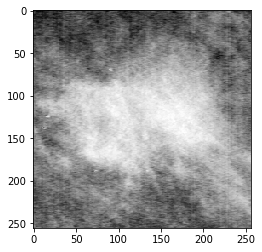

Label: [0. 1.]


In [10]:
idx = 526

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [11]:
def create_vgg19(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [12]:
vgg19_mass_benign_or_malignant_best = create_vgg19(dropout=0.5, fc_size=128, output = 2)

In [13]:
vgg19_mass_benign_or_malignant_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 53,711,298
Trainable params: 33,686,914
Non-trainable params: 20,024,384
___________________________________

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_vgg19_mass_benign_or_malignant_best = vgg19_mass_benign_or_malignant_best.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.3536 - recall: 0.5039
Epoch 00001: val_loss improved from inf to 1.03819, saving model to ../model/vgg19_mass_benign_or_malignant_best.h5
5/5 [==============================] - 14s 3s/step - loss: 1.3163 - recall: 0.4984 - val_loss: 1.0382 - val_recall: 0.5057
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0962 - recall: 0.4747
Epoch 00002: val_loss improved from 1.03819 to 0.69636, saving model to ../model/vgg19_mass_benign_or_malignant_best.h5
5/5 [==============================] - 10s 2s/step - loss: 1.0575 - recall: 0.4770 - val_loss: 0.6964 - val_recall: 0.5057
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9240 - recall: 0.4980
Epoch 00003: val_loss did not improve from 0.69636
5/5 [=======================

4/5 [=======================>......] - ETA: 1s - loss: 0.7044 - recall: 0.5234
Epoch 00029: val_loss did not improve from 0.69116
5/5 [==============================] - 11s 2s/step - loss: 0.7048 - recall: 0.5234 - val_loss: 0.6947 - val_recall: 0.5057
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7260 - recall: 0.5133
Epoch 00030: val_loss did not improve from 0.69116
5/5 [==============================] - 10s 2s/step - loss: 0.7221 - recall: 0.5120 - val_loss: 0.6949 - val_recall: 0.5057
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7127 - recall: 0.4902
Epoch 00031: val_loss did not improve from 0.69116
5/5 [==============================] - 11s 2s/step - loss: 0.7154 - recall: 0.4938 - val_loss: 0.7079 - val_recall: 0.4981
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7131 - recall: 0.4785
Epoch 00032: val_loss did not improve from 0.69116
5/5 [==============================] - 11s 2s/step - loss: 0.7189 - reca

In [16]:
models.save_model(vgg19_mass_benign_or_malignant_best, '../model/vgg19_mass_benign_or_malignant_end.h5')

In [17]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best.history['val_recall']

In [18]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [19]:
print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 44
Epoch [opt]: 14
Valid accuracy [end]: 0.5057
Valid accuracy [opt]: 0.5057
Test accuracy [end]:  0.6164
Test accuracy [opt]:  0.6164
Valid loss [end]: 0.6943
Valid loss [opt]: 0.6912
Test loss [end]:  0.6721
Test loss [opt]:  0.6668


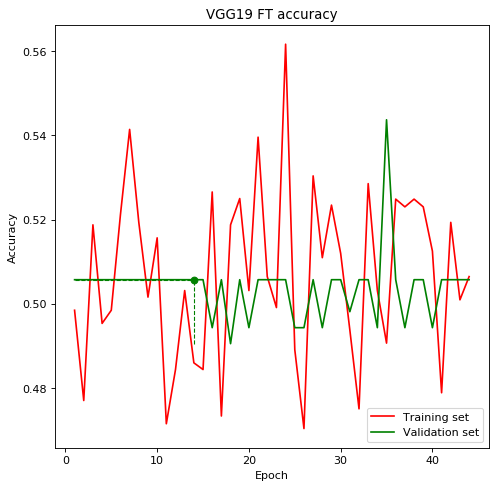

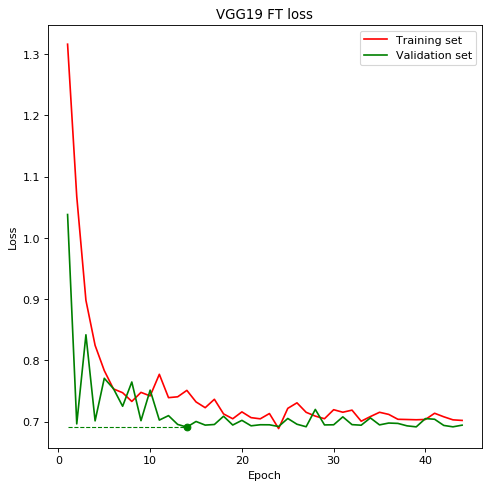

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [ ]:
vgg19_mass_benign_or_malignant_1 = models.load_model('../model/vgg19_mass_benign_or_malignant_best.h5')

for layer in vgg19_mass_benign_or_malignant_1.get_layer('vgg19').layers:
    if layer.name.startswith('block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_mass_benign_or_malignant_1.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])
vgg19_mass_benign_or_malignant_1.summary()
vgg19_mass_benign_or_malignant_1.get_layer('vgg19').summary()

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_mass_benign_or_malignant_1_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [24]:
history_fit = vgg19_mass_benign_or_malignant_1.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5898 - recall: 0.6843
Epoch 00001: val_loss improved from inf to 0.61870, saving model to ../model/vgg19_mass_benign_or_malignant_1_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.6107 - recall: 0.6593 - val_loss: 0.6187 - val_recall: 0.6274
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5781 - recall: 0.6934
Epoch 00002: val_loss did not improve from 0.61870
5/5 [==============================] - 10s 2s/step - loss: 0.5519 - recall: 0.7017 - val_loss: 0.6577 - val_recall: 0.6464
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5678 - recall: 0.7229
Epoch 00003: val_loss improved from 0.61870 to 0.54911, saving model to ../model/vgg19_mass_benign_or_malignant_1_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5849 - recall: 0.6998 - val_loss: 0.549

Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5192 - recall: 0.7168
Epoch 00031: val_loss did not improve from 0.54911
5/5 [==============================] - 10s 2s/step - loss: 0.5463 - recall: 0.7047 - val_loss: 0.5868 - val_recall: 0.6730
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4866 - recall: 0.7446
Epoch 00032: val_loss did not improve from 0.54911
5/5 [==============================] - 10s 2s/step - loss: 0.5104 - recall: 0.7330 - val_loss: 0.5949 - val_recall: 0.6730
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5159 - recall: 0.7108
Epoch 00033: val_loss did not improve from 0.54911
5/5 [==============================] - 10s 2s/step - loss: 0.5129 - recall: 0.7164 - val_loss: 0.5750 - val_recall: 0.6464
Epoch 00033: early stopping


In [25]:
models.save_model(vgg19_mass_benign_or_malignant_1, '../model/vgg19_mass_benign_or_malignant_1_end.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_mass_benign_or_malignant_1 = models.load_model('../model/vgg19_mass_benign_or_malignant_1_best.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant_1.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 38
Epoch [opt]: 8
Valid accuracy [end]: 0.6312
Valid accuracy [opt]: 0.6388
Test accuracy [end]:  0.5556
Test accuracy [opt]:  0.5423
Valid loss [end]: 0.6704
Valid loss [opt]: 0.5725
Test loss [end]:  0.8120
Test loss [opt]:  0.8223


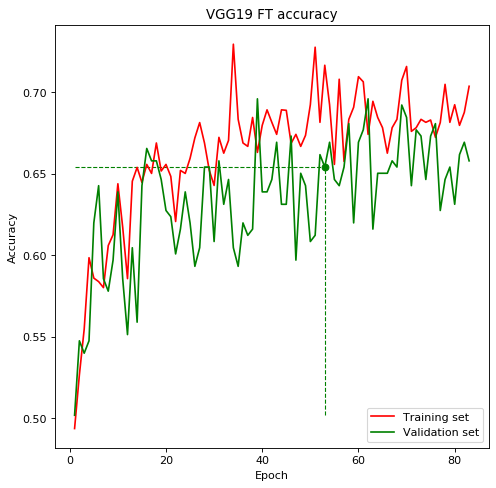

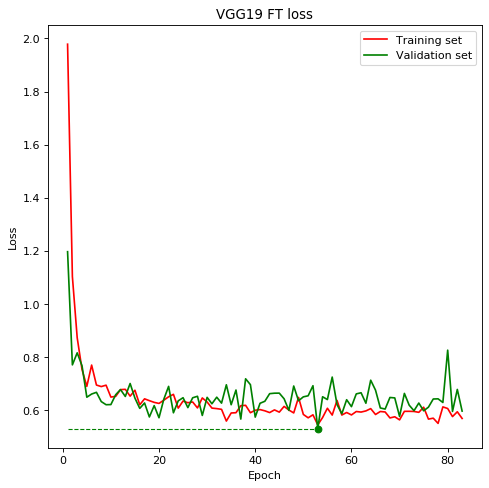

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();